In [ ]:
import numpy as np
import mne
import os

# List of subjects
subjects = [f"S{i:02}" for i in range(1, 21)]

# Paths
error_root = '/Volumes/OrientationDecoding/bids_dirNew/derivatives/CrossDecode'
data_path = '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/'

# Dictionary to store results
subject_data = {}

for subject in subjects:
    print(f"Processing {subject}...")

    # Load epochs
    epoch_path = os.path.join(data_path, f'sub-{subject}_miniEpochs_preprocessed-epo.fif')
    epochs_mini = mne.read_epochs(epoch_path, preload=False)

    # Path to subject's error files
    subject_dir = os.path.join(error_root, subject)
    
    error_list = []
    num_train_times = 961

    for t in range(num_train_times):
        error_file = os.path.join(subject_dir, f"{subject}_errors_{t}.npy")
        if os.path.exists(error_file):
            error_data = np.load(error_file)
            error_list.append(error_data)
        else:
            print(f"Missing: {error_file}")
            # Fallback with NaNs
            error_list.append(np.full((len(epochs_mini), len(epochs_mini.times)), np.nan))

    # Stack shape: (train_time, trials, test_time)
    error_stack = np.stack(error_list, axis=0)

    # Transpose → (trials, test_time, train_time)
    error_stack = np.transpose(error_stack, (1, 2, 0))

    subject_data[subject] = {
        'epochs_mini': epochs_mini,
        'errors': error_stack
    }




In [ ]:
import numpy as np
import mne
import os

# ==== CONFIGURE THIS PART ====
start_train = 0
end_train = 100  # Exclusive
output_dir = "/Volumes/OrientationDecoding/bids_dir/derivatives/CrossDecode/ErrorChunks"
data_path = "/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/"
error_root = "/Volumes/OrientationDecoding/bids_dir/derivatives/CrossDecode"
subjects = [f"S{i:02}" for i in range(1, 21)]
# =============================

os.makedirs(output_dir, exist_ok=True)

# Load all subject data (only the required slice of train times)
subject_data = {}
for subject in subjects:
    print(f"Loading {subject}...")
    epoch_path = os.path.join(data_path, f'sub-{subject}_miniEpochs_preprocessed-epo.fif')
    epochs_mini = mne.read_epochs(epoch_path, preload=False)

    error_list = []
    for t in range(start_train, end_train):
        error_file = os.path.join(error_root, subject, f"{subject}_errors_{t}.npy")
        if os.path.exists(error_file):
            error_data = np.load(error_file)
        else:
            error_data = np.full((len(epochs_mini), len(epochs_mini.times)), np.nan)
        error_list.append(error_data)

    error_stack = np.stack(error_list, axis=0)  # shape: (train_time_subset, trials, test_time)
    error_stack = np.transpose(error_stack, (1, 2, 0))  # (trials, test_time, train_subset)

    subject_data[subject] = {
        "epochs_mini": epochs_mini,
        "errors": error_stack
    }

# Assume all have same shape
example_subj = subjects[0]
n_test_times = subject_data[example_subj]["errors"].shape[1]
n_train_subset = end_train - start_train

# Output
median_errors_partial = np.zeros((n_test_times, n_train_subset))
mad_errors_partial = np.zeros((n_test_times, n_train_subset))

# Time indices per subject
subject_time_idx = {
    subj: {
        tp: subject_data[subj]["epochs_mini"].metadata[
            subject_data[subj]["epochs_mini"].metadata.timepoints == tp
        ].index.to_numpy()
        for tp in range(n_test_times)
    }
    for subj in subjects
}

# Fill matrices
for tp in range(n_test_times):
    for i, train_time in enumerate(range(start_train, end_train)):
        pooled_errors = []
        for subj in subjects:
            s_errors = subject_data[subj]["errors"]  # (trials, test_time, train_subset)
            time_idx = subject_time_idx[subj][tp]
            toplot = s_errors[time_idx, tp, i].flatten()
            pooled_errors.append(toplot)

        pooled = np.concatenate(pooled_errors)
        median_errors_partial[tp, i] = np.median(pooled)
        mad_errors_partial[tp, i] = np.median(np.abs(pooled - np.median(pooled)))

# Save chunk
np.save(os.path.join(output_dir, f"median_partial_{start_train}_{end_train}.npy"), median_errors_partial)
np.save(os.path.join(output_dir, f"mad_partial_{start_train}_{end_train}.npy"), mad_errors_partial)
print(f"Saved plot chunk: {start_train}-{end_train}")


In [1]:
import numpy as np
import mne
import os
import gc  # for garbage collection

# ==== CONFIGURE THIS PART ====
total_train_times = 961
chunk_size = 150
output_dir = '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/!Important Data/error_chunks'
data_path = "/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/"
error_root = "/Volumes/OrientationDecoding/bids_dir/derivatives/CrossDecode"
subjects = [f"S{i:02}" for i in range(1, 21)]
# =============================

os.makedirs(output_dir, exist_ok=True)

# Precompute epoch metadata index lookup once (outside chunk loop) to save time
subject_time_idx = {}
for subj in subjects:
    print(f"Loading metadata for {subj}...")
    epoch_path = os.path.join(data_path, f'sub-{subj}_miniEpochs_preprocessed-epo.fif')
    epochs_mini = mne.read_epochs(epoch_path, preload=False)
    n_test_times = len(epochs_mini.times)
    # store metadata indices and epochs for later
    subject_time_idx[subj] = {
        tp: epochs_mini.metadata[epochs_mini.metadata.timepoints == tp].index.to_numpy()
        for tp in range(n_test_times)
    }
    subject_time_idx[subj]['epochs_mini'] = epochs_mini

start_train = 0
while start_train < total_train_times:
    end_train = min(start_train + chunk_size, total_train_times)
    print(f"Processing train times {start_train} to {end_train-1}...")

    # Load only errors for this chunk for each subject
    subject_data = {}
    for subject in subjects:
        epochs_mini = subject_time_idx[subject]['epochs_mini']

        error_list = []
        for t in range(start_train, end_train):
            error_file = os.path.join(error_root, subject, f"{subject}_errors_{t}.npy")
            if os.path.exists(error_file):
                error_data = np.load(error_file)
            else:
                error_data = np.full((len(epochs_mini), len(epochs_mini.times)), np.nan)
            error_list.append(error_data)

        error_stack = np.stack(error_list, axis=0)  # (train_subset, trials, test_time)
        error_stack = np.transpose(error_stack, (1, 2, 0))  # (trials, test_time, train_subset)

        subject_data[subject] = {
            "epochs_mini": epochs_mini,
            "errors": error_stack
        }

    n_test_times = subject_data[subjects[0]]["errors"].shape[1]
    n_train_subset = end_train - start_train

    median_errors_partial = np.zeros((n_test_times, n_train_subset))
    mad_errors_partial = np.zeros((n_test_times, n_train_subset))

    for tp in range(n_test_times):
        for i, train_time in enumerate(range(start_train, end_train)):
            pooled_errors = []
            for subj in subjects:
                s_errors = subject_data[subj]["errors"]
                time_idx = subject_time_idx[subj][tp]
                toplot = s_errors[time_idx, tp, i].flatten()
                pooled_errors.append(toplot)

            pooled = np.concatenate(pooled_errors)
            median_errors_partial[tp, i] = np.median(pooled)
            mad_errors_partial[tp, i] = np.median(np.abs(pooled - np.median(pooled)))

    # Save results for this chunk
    np.save(os.path.join(output_dir, f"median_partial_{start_train}_{end_train}.npy"), median_errors_partial)
    np.save(os.path.join(output_dir, f"mad_partial_{start_train}_{end_train}.npy"), mad_errors_partial)
    print(f"Saved chunk {start_train}-{end_train-1}")

    # Clear memory for next chunk
    del subject_data
    del median_errors_partial
    del mad_errors_partial
    gc.collect()

    start_train += chunk_size


Loading metadata for S01...
Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/sub-S01_miniEpochs_preprocessed-epo.fif ...
    Found the data of interest:
        t =       0.00 ...      49.17 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
26880 matching events found
No baseline correction applied
0 projection items activated
Loading metadata for S02...
Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/sub-S02_miniEpochs_preprocessed-epo.fif ...
    Found the data of interest:
        t =       0.00 ...      49.17 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
26880 matching events found
No baseline correction applied
0 projection items activated
Loading metadata for S03...
Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/sub-S03_miniEpoc

Median errors matrix shape: (60, 961)
MAD errors matrix shape: (60, 961)


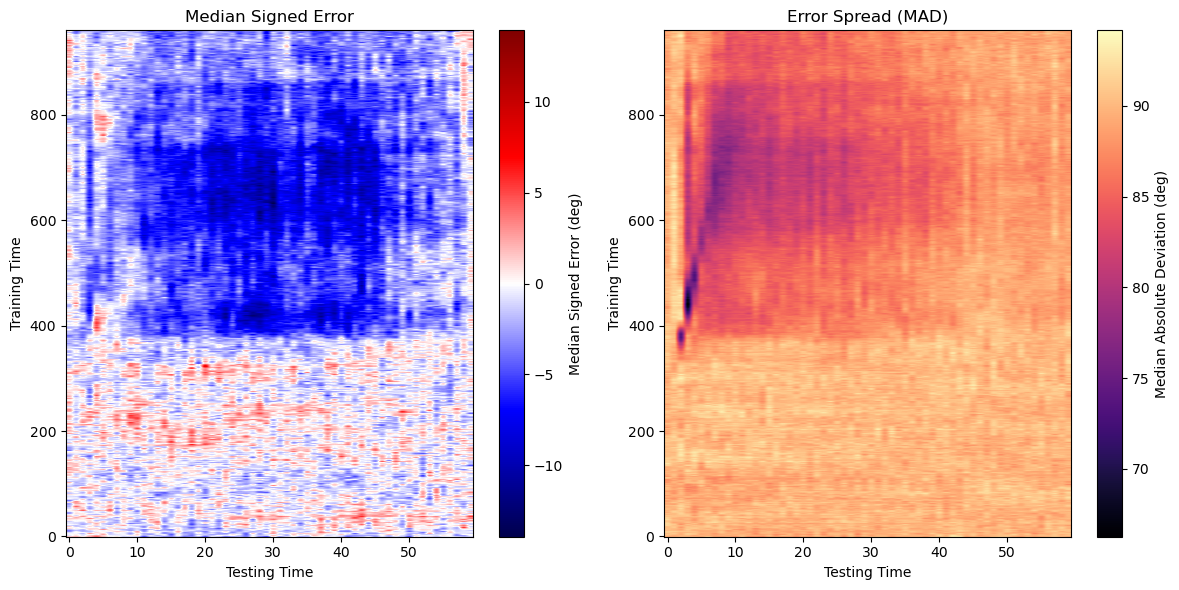

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ==== CONFIGURE THIS PART ====
output_dir = '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/!Important Data/error_chunks'
chunk_size = 150
total_train_times = 961
# =============================

# Find all saved chunk files (assumes consistent naming: median_partial_START_END.npy)
median_files = sorted([f for f in os.listdir(output_dir) if f.startswith("median_partial_")])
mad_files = sorted([f for f in os.listdir(output_dir) if f.startswith("mad_partial_")])

# Load chunks and stitch together
median_chunks = []
mad_chunks = []

for mf, madf in zip(median_files, mad_files):
    median_chunk = np.load(os.path.join(output_dir, mf))
    mad_chunk = np.load(os.path.join(output_dir, madf))
    median_chunks.append(median_chunk)
    mad_chunks.append(mad_chunk)

# Concatenate horizontally along train_time axis (columns)
median_errors_matrix = np.concatenate(median_chunks, axis=1)  # shape: (n_test_times, total_train_times)
mad_errors_matrix = np.concatenate(mad_chunks, axis=1)

# Check shape sanity
print(f"Median errors matrix shape: {median_errors_matrix.shape}")
print(f"MAD errors matrix shape: {mad_errors_matrix.shape}")

# Plot median errors matrix
plt.figure(figsize=(12, 6))
vmax = np.max(np.abs(median_errors_matrix))
vmin = -vmax

plt.subplot(1, 2, 1)
plt.imshow(median_errors_matrix.T, origin="lower", aspect="auto", cmap="seismic", vmin=vmin, vmax=vmax)
plt.colorbar(label="Median Signed Error (deg)")
plt.xlabel("Testing Time")
plt.ylabel("Training Time")
plt.title("Median Signed Error")

# Plot MAD (spread/concentration)
plt.subplot(1, 2, 2)
plt.imshow(mad_errors_matrix.T, origin="lower", aspect="auto", cmap="magma")
plt.colorbar(label="Median Absolute Deviation (deg)")
plt.xlabel("Testing Time")
plt.ylabel("Training Time")
plt.title("Error Spread (MAD)")

plt.tight_layout()
plt.show()
